## Research title: 
## Authors:
### Vladimir Milchev
### Kristofar Stavrev
### Radoslava Dencheva
### Stoyan Stoyanov


# 1. BTC price prediction considering the S&P 500 index using LSTM

## 1.1 Import all necessary libraries

In [5]:
from data_preparation import historical_data_collector
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates # Formatting dates
from lstm import lstm_model
from statsmodels import api as sm
from scipy.stats import linregress
from scipy import stats
import joblib

## 1.2 Load time-series data

In [6]:
#Prepare needed parameters
tickers = {
  "BTC": "BTC-USD",
  "SNP500": "^GSPC",
  #NASDAQ": "^IXIC"
    }

start_date = "2014-09-17"
end_date = datetime.now().strftime('%Y-%m-%d')
target = 'BTC'

collector = historical_data_collector(start_date, end_date, tickers)
df_ext = collector.df
df = df_ext[["BTC", "SNP500"]]
df

,BTC,SNP500
date,,
2014-09-17,457.334015,2001.569946
2014-09-18,424.440002,2011.359985
2014-09-19,394.795990,2010.400024
2014-09-20,408.903992,2010.400024
2014-09-21,398.821014,2010.400024
...,...,...
2022-04-07,43503.847656,4500.209961
2022-04-08,42287.664062,4488.279785
2022-04-09,42782.136719,4488.279785


## 1.3 Explore the Data

### Correlation matrix

In [7]:
correlation = df.corr()
correlation

,BTC,SNP500
BTC,1.000000,0.914981
SNP500,0.914981,1.000000


By looking into our results, we see that we have a strong and positive correlation of 0.91 between the price of Bitcoin and S&P 500. That means that when the prices of the stock market go up, we can expect Bitcoin to follow the trend and also move up.

## Visualize correlation matrix

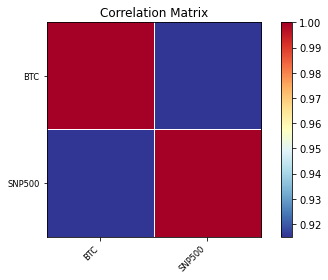

In [8]:
sm.graphics.plot_corr(correlation,xnames=list(correlation.columns))
plt.show()

### Linear regression
__Are SP500 and BTC Statistilcally significant?__
</br>__H0: BTC and Stock prices are not related.__

In [9]:
linregress(df.SNP500,df.BTC)

LinregressResult(slope=19.129162512431652, intercept=-42634.99805853551, rvalue=0.9149810405192388, pvalue=0.0, stderr=0.16051371876897597, intercept_stderr=474.68334586124655)

Since our p-value is lower than 0.05 we can reject H0, and therefore, we can statistically say that Bitcoin and stock prices are moving together.

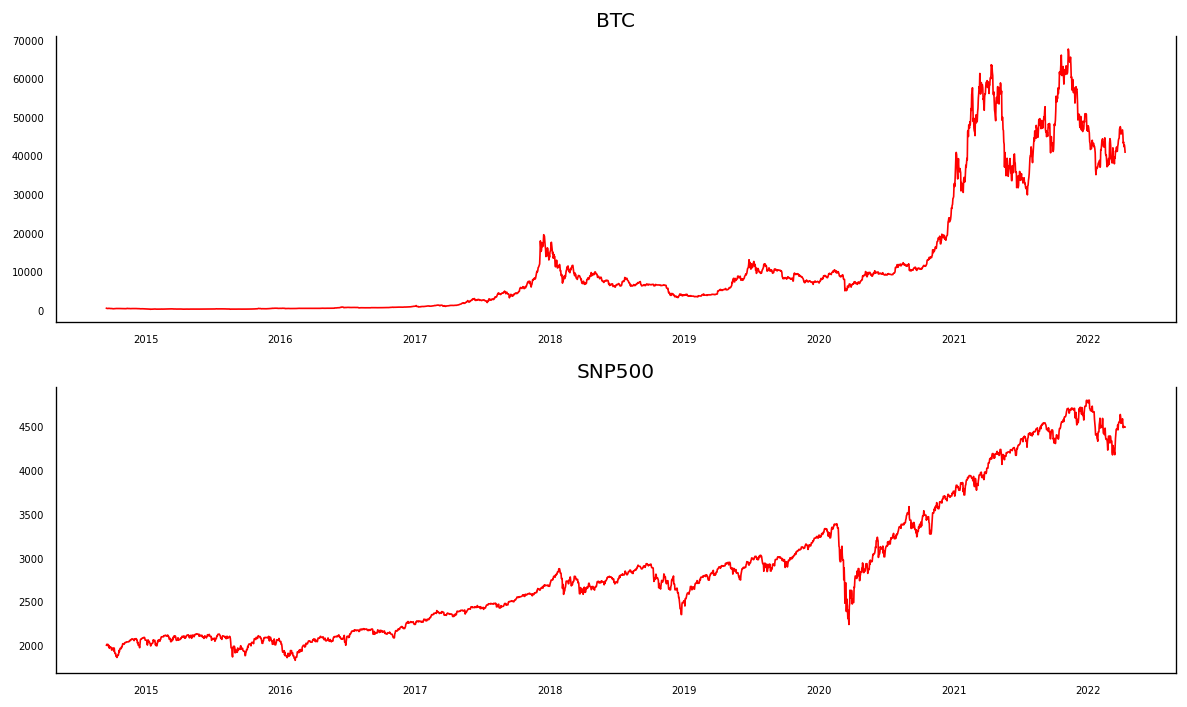

In [10]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
    plt.tight_layout();

Here, we can see different trends for our variables. It would be helpful if we established whether or not our time series followed a normal (or Gaussian) distribution. We will do this based on the test for normality based on the Jarque-Bera test.

### Jarque-Bera Test
Below we will make a Jarque-Bera test to check if the datasets are normally distributed. Here we are going to use the initial dataframes for each of the prices 

In [11]:
def jarque_bera_test(df,column):
    print(f'Performing Jarque-Bera Test for {column}')

    # unpacks the test statistic and p-value from the normaltest of gold
    stat, p = stats.normaltest(df)

    # prints both the test statistic and p-value
    print('Statistics=%.3f, p=%.3f' % (stat, p))

    # chooses an alpha of 0.05 and assigns to variable 'alpha'
    alpha = 0.05

    # creates an if statement for the hypothesis using the p-value test
    if p > alpha:
        print('Data looks Gaussian (fail to reject H0)')
    else:
        print('Data does not look Gaussian (reject H0)')
    
    print("\n" )
for column in df.columns:
    jarque_bera_test(df[column],column)

Performing Jarque-Bera Test for BTC
Statistics=792.182, p=0.000
Data does not look Gaussian (reject H0)


Performing Jarque-Bera Test for SNP500
Statistics=288.019, p=0.000
Data does not look Gaussian (reject H0)




As we can see, we recieve a p-value and a test statistic in return. While we don't have a Chi-Square chart to determine the critical region, we do have a p-value, which is basically zero.

A p-value less than 0.05 basically means our test statistic falls within the critical region (inside the tail); therefore, we can reject the __Ho__. The dataset is not normally distributed, which we probably could have assumed by looking at the time series plots from before.

Next, we can look for a fat-tail distribution and asymmetry by looking for kurtosis and skewness.

## 1.4 Create model

In [12]:
FEATURES = ['BTC', 'SNP500']
data_filtered = df[FEATURES]
lstm_multiple_features = lstm_model(data_filtered, target)

## 1.5 Train model

After preparing the data, we can train the recurrent neural network for bitcoin price prediction. The architecture of our neural network consists of the following four layers:
</br>__Layer 1__ : LSTM layer, which takes our mini-batches as input and returns the whole sequence
</br>__Layer 2__ : LSTM layer that takes the sequence from the previous layer but only returns five values
</br>__Layer 3__ : Dense layer with five neurons
</br>__Layer 4__ : A final dense layer that outputs the predicted value
    
The number of neurons in the first layer must equal the size of a minibatch of the input data. Each minibatch in our dataset consists of a matrix with 50 steps and 2 features. Thus, the input layer of our recurrent neural network consists of 100 neurons.

Epoch 1/50
136/136 [==============================] - 9s 48ms/step - loss: 4.5066e-04 - val_loss: 0.0092
Epoch 2/50
136/136 [==============================] - 7s 48ms/step - loss: 9.6090e-05 - val_loss: 0.0050
Epoch 3/50
136/136 [==============================] - 6s 47ms/step - loss: 8.0642e-05 - val_loss: 0.0062
Epoch 4/50
136/136 [==============================] - 8s 56ms/step - loss: 7.5047e-05 - val_loss: 0.0038
Epoch 5/50
136/136 [==============================] - 7s 49ms/step - loss: 6.8470e-05 - val_loss: 0.0089
Epoch 6/50
136/136 [==============================] - 7s 52ms/step - loss: 5.5105e-05 - val_loss: 0.0071
Epoch 7/50
136/136 [==============================] - 6s 47ms/step - loss: 6.2916e-05 - val_loss: 0.0086
Epoch 8/50
136/136 [==============================] - 7s 53ms/step - loss: 5.5388e-05 - val_loss: 0.0070
Epoch 9/50
136/136 [==============================] - 7s 51ms/step - loss: 4.8153e-05 - val_loss: 0.0022
Epoch 10/50
136/136 [==============================] - 

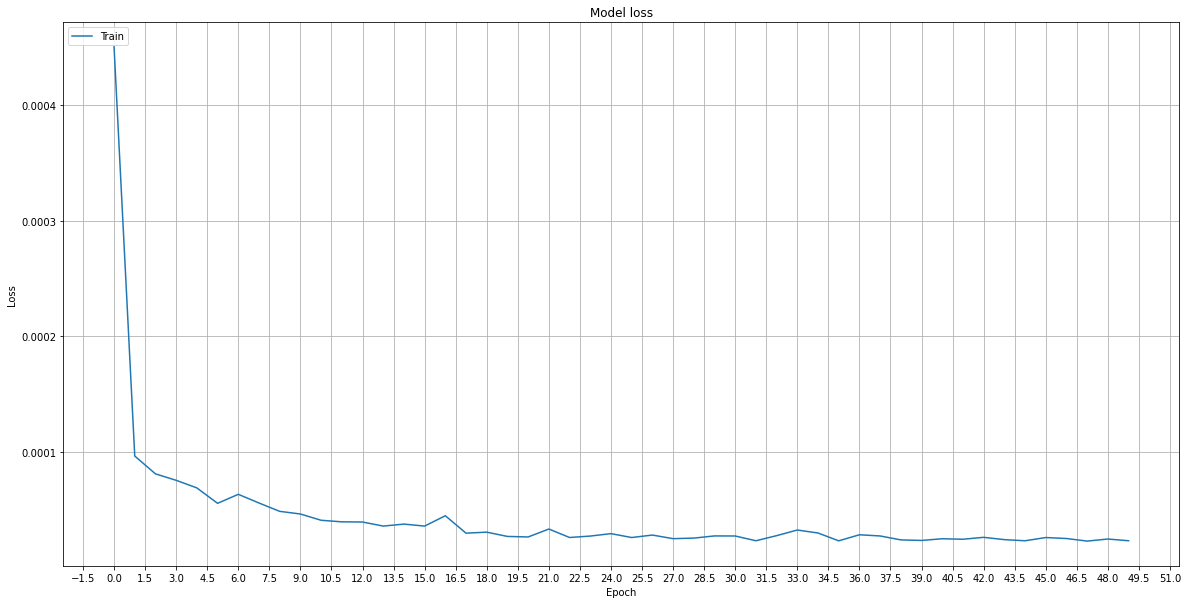

In [13]:
lstm_multiple_features.train()

The loss drops quickly to a lower plateau, which signals that the model has improved throughout the training process.

## 1.6 Evaluate Model Performance

Now that we have trained our model, it is time to look at its performance. But, first, we have to reverse the scaling for the predictions. We will calculate three error metrics, MAE, MAPE, and MDAPE. Then we will compare the predictions in a line plot with the actual values.

In [24]:
from sklearn.preprocessing import  MinMaxScaler
import pandas as pd
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(df['BTC'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)
np_Close_scaled

array([[0.00414359],
       [0.00365546],
       [0.00321557],
       ...,
       [0.63221308],
       [0.62368844],
       [0.60379859]])

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.preprocessing import  MinMaxScaler
#Put model properties to variables
x_test = lstm_multiple_features.x_test
y_test = lstm_multiple_features.y_test

np_Close_scaled = scaler_pred.fit_transform(df_Close)

model = lstm_multiple_features.model

# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)

y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 2575.19
Mean Absolute Percentage Error (MAPE): 5.8 %
Median Absolute Percentage Error (MDAPE): 5.52 %


The MAE is 59.01, which means that the mean of our predictions deviates from the actual values by 3.92%. The MDAPE is 3.67% and a bit lower than the mean, thus indicating there are some outliers among the prediction errors. 50% of the predictions deviate by more than 3.67%, and 50% differ by less than 5.99% from the actual values.

Next, we create a line plot showing the forecast and compare it to the actual values. Adding a bar plot to the chart helps highlight the deviations of the predictions from the actual values.

In [27]:
y_pred

array([[10336.245],
       [10408.429],
       [10652.35 ],
       [10790.627],
       [11028.771],
       [11106.62 ],
       [11276.583],
       [11138.386],
       [11160.719],
       [11222.118],
       [11035.373],
       [11086.628],
       [11207.497],
       [11473.843],
       [11632.065],
       [12573.474],
       [12652.378],
       [12636.924],
       [12836.939],
       [12744.951],
       [12813.908],
       [13410.789],
       [12962.398],
       [13182.376],
       [13270.64 ],
       [13516.148],
       [13451.633],
       [13265.967],
       [13699.683],
       [13841.349],
       [15368.911],
       [15186.285],
       [14451.989],
       [15227.535],
       [14954.783],
       [14953.097],
       [15381.316],
       [15944.937],
       [15916.442],
       [15659.722],
       [15575.979],
       [16402.32 ],
       [17301.225],
       [17364.012],
       [17386.309],
       [18275.232],
       [18172.14 ],
       [17909.78 ],
       [17947.572],
       [18753.18 ],


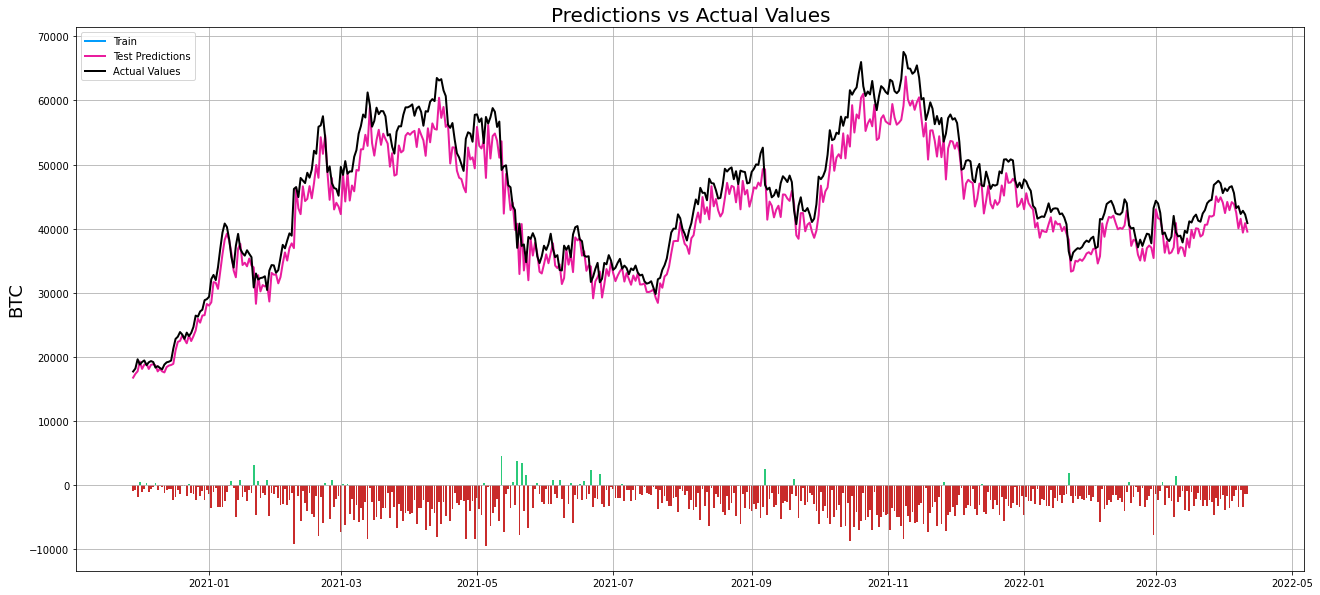

In [29]:
import pandas as pd
from datetime import date, timedelta, datetime
import math

# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=500)

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.index

# Add the difference between the valid and predicted prices
train_data_len = math.ceil(lstm_multiple_features.scaled_data.shape[0] * 0.8)
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["BTC"], True)

# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["BTC"]]
xv = valid['Date']; yv = valid[["BTC", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.ylabel('BTC', fontsize=18)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["BTC"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

## 1.7 Predict Next Day’s Price
After training the neural network, we can forecast the stock market for the next day. For this purpose, we extract a new dataset from the Yahoo-Finance API and preprocess it the same way we did for model training.

We trained our model with mini-batches of 50 time-steps and 2 features. Thus, we also need to provide the model with 50-time steps when making the forecast. As before, we transform the data into the shape of 1 x 50 x 6, whereby the last figure is the number of feature columns. After generating the forecast, we unscale the stock market predictions back to the original range of values.

## __TO DO__